In [5]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import datetime
from scipy import stats
from sklearn import preprocessing
import math
import heapq
import warnings
warnings.filterwarnings('ignore')

In [6]:
# data is the SSE 50 index
data = get_price('000016.XSHG',start_date='2008-03-17',end_date='2019-03-17',frequency='daily')
Close1 = data['close']
High1 = data['high']
Low1 = data['low']
Volume1 = data['volume']
# use Kalman Filter to compute the adjusted data
#Close
KF1 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=Close1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
close_means,_ = KF1.filter(Close1)

Date = pd.to_datetime(data.index)
close_means = pd.DataFrame({'Date':Date,'close_means':pd.DataFrame(close_means)[0]}).set_index('Date')
#High
KF2 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=High1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
high_means,_ = KF2.filter(High1)

high_means = pd.DataFrame({'Date':Date,'high_means':pd.DataFrame(high_means)[0]}).set_index('Date')
#Low
KF3 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=Low1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
low_means,_ = KF3.filter(Low1)

low_means = pd.DataFrame({'Date':Date,'low_means':pd.DataFrame(low_means)[0]}).set_index('Date')
#Volume
KF4 = KalmanFilter(transition_matrices=[1],
                 observation_matrices=[1],
                 initial_state_mean=Volume1[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)
volume_means,_ = KF4.filter(Volume1)

volume_means = pd.DataFrame({'Date':Date,'volume_means':pd.DataFrame(volume_means)[0]}).set_index('Date')
# calculate characteristic variables
logdif = np.log(np.array(high_means['high_means']))-np.log(np.array(low_means['low_means']))
logret5 = np.log(np.array(close_means['close_means'][5:]))-np.log(np.array(close_means['close_means'][:-5]))
logvoldif5 = np.log(np.array(volume_means['volume_means'][5:]))-np.log(np.array(volume_means['volume_means'][:-5]))
logdif = logdif[5:]
close = data['close'][5:]
Date = pd.to_datetime(data.index[5:])
# Box-Cox transformation and stardardization
bc_logdif,_ = stats.boxcox(logdif)
scale_bc_logdif = preprocessing.scale(bc_logdif,axis=0,with_mean=True,with_std=True,copy=False)
scale_logret5 = preprocessing.scale(logret5,axis=0,with_mean=True,with_std=True,copy=False)
scale_logvoldif5 = preprocessing.scale(logvoldif5,axis=0,with_mean=True,with_std=True,copy=False)
# compute inpute variable scaleA
scaleA = np.column_stack([scale_bc_logdif,scale_logret5,scale_logvoldif5])

In [12]:
index = 0
# set data from 2008-03-17 to 2018-03-17 be the training data
T = len((get_price('000016.XSHG',start_date='2008-03-17',end_date='2018-03-17',frequency='daily'))[5:])
long_num = 0
ret = 1
long_win = 0
short_num = 0
short_win = 0
cumret = []
while index+T<=int(len(scaleA)-1):
    HMMmodel = GaussianHMM(n_components=4,covariance_type='full',n_iter=2000).fit(scaleA[index:index+T])
    history_info = []
    hidden_states = HMMmodel.predict(scaleA[index:index+T])
    for i in range(index,index+T):       
        score = HMMmodel.score(scaleA[i:i+1])
        day_tuple = (i,hidden_states[i-index],score)
        history_info.append(day_tuple)
    
    last_hidden_states = history_info[-1][1]
    last_score = history_info[-1][2]
    
    same_states = []
    for (x,y,z) in history_info[:-1]:
        if y==last_hidden_states:
            diff = abs(z-last_score)
            same_states.append((x,diff))
     
    pos_diffs = heapq.nsmallest(30,same_states,key=lambda s:s[1]) # find 30 days with the smallest likelyhood value
    weights = []
    returns = []
    sum_diffs = sum(1/x[1] for x in pos_diffs)
    for (x,y) in pos_diffs:
        weights.append(1/y/sum_diffs)
        returns.append(close[x+1]/close[x]-1)
    weights = np.array(weights)
    returns = np.array(returns)
    weighted_score = np.dot(weights,returns.T)
    real_return = close[index+T]/close[index+T-1]-1
    
    if weighted_score>0:
        long_num += 1
        ret *=(1+real_return)
        if close[index+T]>close[index+T-1]:
            long_win += 1
    elif weighted_score<0:
        short_num += 1
        ret /=(1+real_return)
        if close[index+T]<close[index+T-1]:
            short_win += 1
    else:
        pass
    cumret.append(ret)
    index += 1
    
print('---------------------------------------')
        
        

---------------------------------------


In [19]:
cumreturns = pd.DataFrame({'Date':Date[T-1:-1],'cumreturns':cumret}).set_index('Date')

多头胜率：52.42%
空头胜率：55.08%


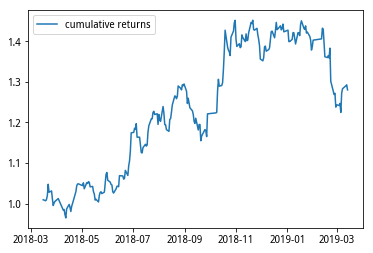

In [25]:
# plot cumulative return
# compute victory ratio in both long and short position
plt.plot(cumreturns,label='cumulative returns')
plt.legend(loc='upper left')
print('多头胜率：'+ str(round(100*long_win/long_num,2))+'%')
print('空头胜率：'+ str(round(100*short_win/short_num,2))+'%')